# r/ffxiv Experiment Dataframe Creation
July 2020

J. Nathan Matias and Eric Pennington

### Libraries and environment

In [1]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, csv, uuid, datetime, jsonlines
from bloom_filter import BloomFilter

os.environ['AIRBRAKE_API_KEY'] = "ca826dbd1a4594241c239bba825edd9f" ## EDIT BEFORER USING
os.environ['AIRBRAKE_PROJECT_ID'] = "-1" ## EDIT BEFORE USING

import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/usr/local/civilservant/platform"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, and_, or_
import sqlalchemy.orm.session
import utils.common


db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
# import reddit.connection
# conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")
# r = conn.connect(controller="Jupyter")

from app.models import *

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

Logging to /usr/local/civilservant/platform/logs/CivilServant_production.log


# Global Experiment Settings

In [64]:
subreddit_id = "2rgs7"
data_dir = "~/Tresors/CivilServant/projects/CivilServant-reddit/r-ffxiv-2020"

# Create a Dataset of Posts Appearing In the Experiment

In [3]:
experiment_posts = []
for row in db_engine.execute(text("""
select * from experiment_things 
  JOIN posts on experiment_things.id = posts.id 
  WHERE object_type=1 
    AND (experiment_id=15 OR experiment_id=16)
  ORDER BY posts.created ASC;

""")):
    post = {}
    for key in row.keys():
        post[key]=row[key]
    metadata = json.loads(row['metadata_json'])
    for key in metadata['randomization'].keys():
        post[key] = metadata['randomization'][key]
    post['treat.number'] = int(post[''])
    del post['']
    del post['metadata_json']
    post['post_data']  = json.loads(post['post_data'])
    experiment_posts.append(post)

In [4]:
print("{0} posts have been assigned to treatment or control in the experiment.".format(len(experiment_posts)))
earliest_date = experiment_posts[0]['created']
latest_date = experiment_posts[-1]['created']
print("Earliest Date: {0}".format(earliest_date))
print("Latest Date: {0}".format(latest_date))

12100 posts have been assigned to treatment or control in the experiment.
Earliest Date: 2019-07-06 12:26:30
Latest Date: 2019-08-24 19:06:05


#### Get Replies to the Sticky Comment (sticky_comment_ffxiv_07_2019.yml)

In [5]:
import app.controllers.sticky_comment_experiment_controller as scec
import logging

## hack: we may not need to actually query PRAW here, so setting it to None
r = None

experiment = scec.StickyCommentExperimentController("sticky_comment_ffxiv_07_2019", 
                                                    db_session,
                                                    r,
                                                    logging.getLogger("Analysis"),
                                                    required_keys={}) # another hack
experiment_07_comments = experiment.get_comment_objects_for_experiment_comment_replies(
    experiment.get_all_experiment_comment_replies()
)

print("experiment_07_comments experiment had {0} replies to experiments".format(
        len(experiment_07_comments)))

experiment_07_comments experiment had 0 replies to experiments


#### Get Replies to the Sticky Comment (sticky_comment_ffxiv_08_2019.yml)

In [6]:
import app.controllers.sticky_comment_experiment_controller as scec
import logging
experiment = scec.StickyCommentExperimentController("sticky_comment_ffxiv_08_2019", 
                                                    db_session,
                                                    r,
                                                    logging.getLogger("Analysis"),
                                                    required_keys={})
experiment_08_comments = experiment.get_comment_objects_for_experiment_comment_replies(
    experiment.get_all_experiment_comment_replies()
)

print("experiment_08_comments experiment had {0} replies to experiments".format(
        len(experiment_08_comments)))

experiment_08_comments experiment had 0 replies to experiments


### Load Moderator Actions Between the Earliest Date and One Week After the Final Post

In [7]:
recent_mod_actions = []
for row in db_engine.execute(text("""
SELECT action_data FROM mod_actions 
    WHERE subreddit_id="{0}" AND 
          created_utc >= "{1}" AND
          created_utc <= "{2}"
    ORDER BY created_utc;
""".format(subreddit_id,
           earliest_date,
           latest_date +  datetime.timedelta(days=7)))):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

49497 moderator actions loaded


### Tag posts as visible or non-visible based on moderation log
Also: create study_posts, which is the dict used to create the final dataframe

In [8]:
study_posts = {}
for post in experiment_posts:
    post['visible'] = True
    study_posts[post['id']] = post
recent_post_count = len(study_posts.values())
print("Post Count: {0}".format(recent_post_count))

missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in study_posts.keys():
            study_posts[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in study_posts.keys():
            study_posts[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
#print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
# print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))

Post Count: 12100
Matched Mod Actions: 4160


# Create a Dataset of Comments In the Experiment
## Create List of Newcomer Accounts
Six months before 2019-07-06 12:26:30

In [9]:
cutoff_time = parser.parse("2019-07-06 12:26:30")
cutoff_time

datetime.datetime(2019, 7, 6, 12, 26, 30)

In [10]:
all_accounts = set()
for filename in glob.glob("ffxiv*.ndjson"):
    print(filename)
    with jsonlines.open(filename) as reader:
        for comment in reader:
            timestamp = datetime.datetime.utcfromtimestamp(comment['created_utc'])
            if(timestamp < cutoff_time and 
               timestamp > cutoff_time - datetime.timedelta(days=30*6)):
                all_accounts.add(comment['author'])       

ffxiv-comments-2019-01.ndjson
ffxiv-comments-2019-06.ndjson
ffxiv-comments-2019-08.ndjson
ffxiv-comments-2019-02.ndjson
ffxiv-comments-2019-03.ndjson
ffxiv-comments-2019-05.ndjson
ffxiv-comments-2019-04.ndjson
ffxiv-comments-2019-07.ndjson


In [11]:
print("{0} total accounts".format(len(all_accounts)))

61560 total accounts


### Create Dict of Backfill Comments

In [12]:
backfill_comments = {}

for filename in ["ffxiv-comments-2019-07.ndjson",
                 "ffxiv-comments-2019-08.ndjson"]:
    print(filename)
    with jsonlines.open(filename) as reader:
        for comment in reader:
            comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(comment['created_utc']))
            comment['body.length'] = len(comment['body'])
            comment['body'] = None
            comment['body_html'] = None
            comment['visible'] = True
            backfill_comments[comment['id']] = comment
print("{0} available backfill comments".format(len(backfill_comments)))

ffxiv-comments-2019-07.ndjson
ffxiv-comments-2019-08.ndjson
537133 available backfill comments


### Pull Comments Observed by CivilServant during the Experiment

In [13]:
dbcomments = {}

comment_query = """
SELECT * FROM comments 
    WHERE subreddit_id="{0}" AND 
          created_utc >= "{1}" AND
          created_utc <= "{2}";
"""


for row in db_engine.execute(text(comment_query.format(subreddit_id,
           earliest_date,
           latest_date +  datetime.timedelta(days=7)))):
    
    comment = {}
    for key in row.keys():
        comment[key] = row[key]
    comment_data = json.loads(comment['comment_data'])
    for key in comment_data.keys():
        comment[key] = comment_data[key]
    del comment['comment_data']

    comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(comment['created_utc']))
    comment['body.length'] = len(comment['body'])
    comment['body'] = None
    comment['body_html'] = None
    comment['visible'] = True

    dbcomments[comment['id']] = comment

print("{0} comments actions loaded".format(len(recent_mod_actions)))

49497 comments actions loaded


### Make a dict of all comments

In [14]:
## all_comments will have a dict of all comments
## with dbcomments overwriting backfilled ones
## and with keys being the comment ID
all_comments = copy.copy(backfill_comments)
all_comments.update(dbcomments)

print("{0} in all comments".format(len(all_comments)))
print("{0} in all dbcomments".format(len(dbcomments)))
print("{0} in all backfill_comments".format(len(backfill_comments)))

#summary: there are no comments we have that jason didn't observe

537133 in all comments
438880 in all dbcomments
537133 in all backfill_comments


### Identify Missing Comments from Moderation Log

In [15]:
import re
missing_comment_ids = []
missing_comment_actions = []
for action in recent_mod_actions:
    if action['target_fullname'] is not None and "t1_" in action['target_fullname']:
        link_id = re.search('/r/ffxiv/comments/(.*?)/', action['target_permalink']).group(1)
        if action['target_fullname'].replace("t1_", "") not in all_comments.keys():
            missing_comment_ids.append(action['target_fullname'])
            missing_comment_actions.append(action)
print("Missing Comments: {0}".format(len(missing_comment_ids)))

Missing Comments: 31


In [16]:
#missing_comment_ids

### TODO: Use Existing Metadata to Integrate Records about Missing Comments Into the Final Dataset

### Identify comments that are replies to sticky comment actions

In [17]:
## step one: query all experiment_actions that were sticky comments
## select action_subject_id from experiment_actions WHERE experiment_id IN (15,16) AND action="Intervention" AND action_subject_id IS NOT NULL;
action_query = """
SELECT action_subject_id FROM experiment_actions 
    WHERE experiment_id IN ("{0},{1}") 
    AND action_subject_id IS NOT NULL
"""

sticky_comment_ids = []

for row in db_engine.execute(text(action_query.format(15,16))):
    sticky_comment_ids.append("t1_" + row['action_subject_id'])

replies_to_sticky = 0
for comment in all_comments.values():
    if(comment['parent_id'] in sticky_comment_ids):
        replies_to_sticky += 1
print("{0} replies to stickies".format(replies_to_sticky))

0 replies to stickies


### Construct a time sorted list of comments on the sampled posts

In [18]:
import heapq

EPOCH = utc.localize(datetime.datetime.utcfromtimestamp(0))

class CommentHeapObj(object):
    def __init__(self, comment):
        self.index = int((comment['created'] - EPOCH).total_seconds())
        self.val = comment
    def __lt__(self, other):
        return self.index < other.index

def heapsort(comments):
    h = []
    for comment in comments:
        heapq.heappush(h, CommentHeapObj(comment))
    return [heapq.heappop(h).val for i in range(len(h))]

all_comments = heapsort(all_comments.values())

### Add Moderation Actions to Comments, Setting Comments as Visible or Not Visible

In [19]:
from collections import defaultdict, Counter
mod_comment_actions = defaultdict(list)
approved_count = 0
removed_count = 0
total_coments_removed_at_least_once = []
comments_with_mod_actions = set()

for action in recent_mod_actions:
     if action['action'] == "removecomment" or action['action'] == "approvecomment":
            comment_id = action['target_fullname'].replace("t1_", "")
            mod_comment_actions[comment_id].append(action)
            comments_with_mod_actions.add(action['target_fullname'])

print("{0} Total moderation actions".format(sum([len(x) for x in mod_comment_actions.values()])))
print("{0} Comments with moderation actions".format(len(mod_comment_actions)))
print("{0} Comments with more than one mod action".format(len([x for x in mod_comment_actions.values() if len(x)>1])))
print("")

for comment in all_comments:
    if('later_deleted' not in comment.keys()):
        comment['later_deleted'] = False
        if(comment['author'] =="[deleted]"):
            comment['later_deleted'] = True
    if comment['id'] in mod_comment_actions.keys():
        for action in mod_comment_actions[comment['id']]:
            ## many authors are later deleted, so try to 
            ## add in the author information here, since
            ## the moderation log retains the author information
            comment['author']  = action['target_author']
            if action['action'] =="removecomment":
                removed_count += 1
                total_coments_removed_at_least_once.append(comment['id'])
                comment['visible'] = False
            elif action['action'] == "approvecomment":
                approved_count += 1
                comment['visible']  = True
print("Summary of Comment Visibility:")
print(Counter([x['visible'] for x in all_comments]))
print("Took {0} actions to set a comment to removed".format(removed_count))
print("Took {0} actions to set a comment to approved".format(approved_count))

4734 Total moderation actions
4482 Comments with moderation actions
227 Comments with more than one mod action

Summary of Comment Visibility:
Counter({True: 533881, False: 3252})
Took 3386 actions to set a comment to removed
Took 1319 actions to set a comment to approved


### Add Author Comment Number to All Comments

In [20]:
author_comment_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.comments'] = author_comment_num[comment['author']]    
    author_comment_num[comment['author']] += 1

### Add Author Removed Count to All Comments

In [21]:
from collections import defaultdict, Counter

author_removed_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.removed'] = author_removed_num[comment['author']]  
    if(comment['visible']==False):
        author_removed_num[comment['author']] += 1

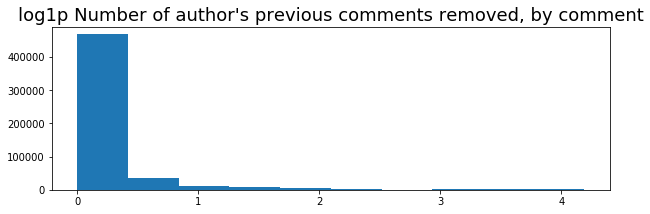

In [22]:
import math
plt.figure(figsize=(10, 3)) 
plt.hist([math.log1p(x['author.prev.removed']) for x in all_comments])
plt.title("log1p Number of author's previous comments removed, by comment", fontsize="18")
plt.show()

# Merge Post Data into Comments for Analysis: 

In [34]:
all_experiment_comment_ids = [x.id for x in experiment_07_comments] + [x.id for x in experiment_08_comments]

recent_comments_included = []
experiment_comments = []
for comment in all_comments:
    if(comment['author'] == "CivilServantBot"):
        experiment_comments.append(comment)
        continue
    post_id = comment['link_id'].replace("t3_", "")
    if(post_id in study_posts.keys()):
        post = study_posts[comment['link_id'].replace("t3_", "")]
        post_created = utc.localize(post['created'])
        
        comment['intervention.reply'] = comment['id'] in all_experiment_comment_ids
        comment['post.created'] = post['created']
        comment['minutes.since.post.created'] = (comment['created'] - post_created).total_seconds() / 60.
        comment['post.author'] = post['post_data']['author']
        comment['post.visible'] = post['visible']
        comment['toplevel'] = comment['link_id'] == comment['parent_id']
        comment['post.domain'] = post['post_data']['domain']
        comment['post.day.num']  = (post_created - utc.localize(datetime.datetime(1970,1,1))).days
        comment['day.num'] = (comment['created'] - utc.localize(datetime.datetime(1970,1,1))).days
        comment['weekday'] = comment['created'].weekday()
        comment['weekend'] = (comment['weekday'] >=6)
        comment['post.treatment'] = int(post['treatment'])
        comment['post.assign.number']  = int(post['treat.number'])
        comment['post.block.id'] = post['block.id']
        comment['post.block.size']  = post['block.size']

        recent_comments_included.append(comment)


# Merge Comment Data into Posts for Analysis: 

In [39]:
for post in study_posts.values():
    post['newcomer.comments'] = 0
    post['newcomer.comments.experiment.day'] = 0
    post['newcomer.comments.experiment.after'] = 0

    post['newcomer.comments.removed'] = 0
    post['newcomer.comments.removed.experiment.day'] = 0
    post['newcomer.comments.removed.experiment.after'] = 0

    post['commenters'] = set()
    
    post['experiment.day'] = post['created'].replace(hour = 5, minute=0, second=0)
    post['experiment.day.next'] = (post['experiment.day'] + datetime.timedelta(days=1))
    post['experiment.day.minutes'] = int((post['experiment.day.next'] - post['created']).total_seconds() / 60.)
                                                                      
    post['num.comments']  = 0
    post['num.comments.removed'] = 0
    post['num.comments.removed.experiment.day'] = 0
    post['num.comments.removed.experiment.after'] = 0
    
    post['num.comments.experiment.replies'] = 0
    post['newcomer.comments.experiment.replies'] = 0
                                   
    post['weekday'] = post['created'].weekday()
    post['weekend'] = (post['weekday'] >=6)
    
for comment in recent_comments_included:
    post = study_posts[comment['link_id'].replace("t3_", "")]
    post['commenters'].add(comment['author'])
    
    
    if(comment['id'] in all_experiment_comment_ids):
        post['num.comments.experiment.replies'] += 1
    else:
        post['num.comments'] += 1
    
    if(comment['visible']!=True):
        post['num.comments.removed'] +=1
        
    ## IF THE COMMENT AUTHOR IS A NEWCOMER
    if comment['author.prev.comments'] == 0:
        post['newcomer.comments'] += 1
        
        if(comment['id'] in all_experiment_comment_ids):
            post['newcomer.comments.experiment.replies'] += 1
                
        if(comment['visible']!=True):
            post['newcomer.comments.removed'] += 1

for post in study_posts.values():
    post['num.commenters'] = len(post['commenters'])
    del post['commenters']

# Output Dataframes

## Post Dataframe

In [58]:
post_cols=['block.id', 
               'num.commenters', 
               'num.comments.removed', 
               'newcomer.comments.removed',
               'weekday',
               'weekend',
               'num.comments',
               'newcomer.comments', 
               'visible', 
               'created',
               'treatment']

In [69]:
pd.DataFrame([{k: v for k, v in x.items() if k in post_cols} for x in study_posts.values()]).to_csv(
    os.path.join(data_dir, "r-ffxiv-posts-{0}.csv".format(datetime.datetime.utcnow().strftime('%m.%d.%Y'))),
    index=False
)

## Comment Dataframe

In [73]:
comment_cols=['body.length',
              'subreddit_id',
#              'author',
#              'author.prev.removed', 
              'is_submitter', 
              'author.prev.comments',
              'visible',
              'created',
#              'weekend',
#              'weekday',
              'post.block.id',
              'post.treatment']

In [77]:
## filter 
print("Total comments: {0}".format(len(recent_comments_included)))
print("First time comments: {0}".format(len([x for x in recent_comments_included if x['author.prev.comments']==0])))

Total comments: 345387
First time comments: 23495


In [79]:
pd.DataFrame([{k: v for k, v in x.items() if k in post_cols} for x in recent_comments_included if x['author.prev.comments']==0]).to_csv(
    os.path.join(data_dir, "r-ffxiv-newcomer-comments-{0}.csv".format(datetime.datetime.utcnow().strftime('%m.%d.%Y'))),
    index=False
)